# CS895 - Assignment04
## K-Means & PCA

There are **7 Questions** in this assignment. All are mandatory. Do the assignment on Google CoLab. Write your code in the cells for each question and submit this notebook on LMS. 

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 204.2MB 65kB/s 
     |████████████████████████████████| 204kB 49.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=a723378ef8b5936264805d365734ccc31b4794ec2c62848e818af10fd6742b10
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

Now we import some of the libraries usually needed by our workload.





In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [4]:
spark

### Data Preprocessing

In this Colab, rather than downloading a file from Google Drive, we will load a famous machine learning dataset, the [Breast Cancer Wisconsin dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), using the ```scikit-learn``` datasets loader.

In [5]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()

For convenience, given that the dataset is small, we first construct a Pandas dataframe, tune the schema, and then convert it into a Spark dataframe.

In [6]:
pd_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df = spark.createDataFrame(pd_df)

def set_df_columns_nullable(spark, df, column_list, nullable=False):
    for struct_field in df.schema:
        if struct_field.name in column_list:
            struct_field.nullable = nullable
    df_mod = spark.createDataFrame(df.rdd, df.schema)
    return df_mod

df = set_df_columns_nullable(spark, df, df.columns)
df = df.withColumn('features', array(df.columns))
vectors = df.rdd.map(lambda row: Vectors.dense(row.features))

df.printSchema()

root
 |-- mean radius: double (nullable = false)
 |-- mean texture: double (nullable = false)
 |-- mean perimeter: double (nullable = false)
 |-- mean area: double (nullable = false)
 |-- mean smoothness: double (nullable = false)
 |-- mean compactness: double (nullable = false)
 |-- mean concavity: double (nullable = false)
 |-- mean concave points: double (nullable = false)
 |-- mean symmetry: double (nullable = false)
 |-- mean fractal dimension: double (nullable = false)
 |-- radius error: double (nullable = false)
 |-- texture error: double (nullable = false)
 |-- perimeter error: double (nullable = false)
 |-- area error: double (nullable = false)
 |-- smoothness error: double (nullable = false)
 |-- compactness error: double (nullable = false)
 |-- concavity error: double (nullable = false)
 |-- concave points error: double (nullable = false)
 |-- symmetry error: double (nullable = false)
 |-- fractal dimension error: double (nullable = false)
 |-- worst radius: double (nullable

With the next cell, we build the two datastructures that we will be using throughout this Colab:


*   ```features```, a dataframe of Dense vectors, containing all the original features in the dataset;
*   ```labels```, a series of binary labels indicating if the corresponding set of features belongs to a subject with breast cancer, or not.



In [7]:
from pyspark.ml.linalg import Vectors
features = spark.createDataFrame(vectors.map(Row), ["features"])
labels = pd.Series(breast_cancer.target)

#**Question01:**



If you run successfully the Setup and Data Preprocessing stages, you are now ready to cluster the data with the [K-means](https://spark.apache.org/docs/latest/ml-clustering.html) algorithm included in MLlib (Spark's Machine Learning library).
Set the ```k``` parameter to **2**, fit the model, and the compute the [Silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) (i.e., a measure of quality of the obtained clustering).  

**IMPORTANT:** use the MLlib implementation of the Silhouette score (via ```ClusteringEvaluator```).

In [68]:
# YOUR CODE HERE


from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(features)

# Make predictions
predictions = model.transform(features)

#print(predictions.toPandas())

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


Silhouette with squared euclidean distance = 0.8342904262826145
Cluster Centers: 
[1.25562991e+01 1.85703653e+01 8.11234703e+01 4.96061872e+02
 9.48844977e-02 9.10998174e-02 6.24377642e-02 3.34325434e-02
 1.78057991e-01 6.34540183e-02 3.04190868e-01 1.21515320e+00
 2.15288059e+00 2.37852922e+01 7.17326256e-03 2.34746895e-02
 2.87455128e-02 1.06363242e-02 2.06135799e-02 3.74750297e-03
 1.40439018e+01 2.47095434e+01 9.19375114e+01 6.19647945e+02
 1.29959110e-01 2.23311758e-01 2.19214947e-01 9.13298425e-02
 2.83553653e-01 8.32819406e-02]
[1.93799237e+01 2.16945802e+01 1.28231298e+02 1.18592977e+03
 1.01294580e-01 1.48612977e-01 1.76939466e-01 1.00698779e-01
 1.91539695e-01 6.06029008e-02 7.42803817e-01 1.22253817e+00
 5.25058015e+00 9.56781679e+01 6.59868702e-03 3.21766947e-02
 4.24197710e-02 1.56739847e-02 2.03039695e-02 3.95338931e-03
 2.37094656e+01 2.89126718e+01 1.58496183e+02 1.75302290e+03
 1.40424733e-01 3.57757710e-01 4.49306107e-01 1.92431069e-01
 3.11881679e-01 8.61654962e-02]


#**Question02:**

Compute the within cluster sum of squares (WSS) using your **OWN** method in Spark. Note that the score can be be obtained using the `summary.trainingCost` method of the fitted kmeans model.

In [69]:
# YOUR CODE HERE
# Evaluate clustering.
cost = model.summary.trainingCost
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 77943099.87829885


#**Question03:**

**Take** the predictions produced by K-means, and compare them with the ```labels``` variable (i.e., the ground truth from our dataset).  

Compute how many data points in the dataset have been clustered correctly (i.e., positive cases in one cluster, negative cases in the other).

*HINT*: you can use ```np.count_nonzero(series_a == series_b)``` to quickly compute the element-wise comparison of two series.

**IMPORTANT**: K-means is a clustering algorithm, so it will not output a label for each data point, but just a cluster identifier!  As such, label ```0``` does not necessarily match the cluster identifier ```0```.


In [70]:
# YOUR CODE HERE

correct_pred=np.count_nonzero(np.array(predictions.select('prediction').collect()) != np.array(labels).reshape(-1, 1))
print("# of correctly clustered Data points  = " + str(correct_pred))

# of correctly clustered Data points  = 486


#**Question03:**

Now perform dimensionality reduction on the ```features``` using the [PCA](https://spark.apache.org/docs/latest/ml-features.html#pca) statistical procedure, available as well in MLlib.

Set the ```k``` parameter to **2**, effectively reducing the dataset size of a **15X** factor.

In [71]:
# YOUR CODE HERE
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors


pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
#pca.explained_variance_ratio_
model = pca.fit(features)

result = model.transform(features).select("pcaFeatures")
print(result)
result.show(truncate=False)

DataFrame[pcaFeatures: vector]
+-----------------------------------------+
|pcaFeatures                              |
+-----------------------------------------+
|[-2260.0138862925405,-187.9603012226368] |
|[-2368.993755782054,121.58742425815508]  |
|[-2095.6652015478608,145.11398565870087] |
|[-692.6905100570508,38.576922592081765]  |
|[-2030.2124927427062,295.2979839927924]  |
|[-888.280053576076,26.079796157025726]   |
|[-1921.082212474845,58.807572473099206]  |
|[-1074.7813350047961,31.771227808469668] |
|[-908.5784781618829,63.83075279044624]   |
|[-861.5784494075679,40.57073549705321]   |
|[-1404.559130649947,88.23218257736237]   |
|[-1524.2324408687816,-3.2630573167779793]|
|[-1734.385647746415,273.1626781511459]   |
|[-1162.9140032230355,217.63481808344613] |
|[-903.4301030498832,135.61517666084782]  |
|[-1155.8759954206848,76.80889383742165]  |
|[-1335.7294321308068,-2.4684005450356024]|
|[-1547.2640922523087,3.805675972574325]  |
|[-2714.9647651812156,-164.37610864258804]|
|

In [72]:
result =result.withColumnRenamed("pcaFeatures", "features")

#**Question04:**

Now run K-means with the same parameters as above, but on the ```pcaFeatures``` produced by the PCA reduction you just executed.


In [73]:
# YOUR CODE HERE

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(result)

# Make predictions
predictions_pca = model.transform(result)
#print(predictions_pca.toPandas())


#**Question05:**

Compute the Silhouette score, as well as the number of data points that have been clustered correctly.

In [74]:
# YOUR CODE HERE
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions_pca)
print("Silhouette with squared euclidean distance (AFTER PCA) = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance (AFTER PCA) = 0.8348610363444836
Cluster Centers: 
[-793.36109344  105.48246852]
[-2124.69173996   107.54465437]


In [75]:
correct_pred=np.count_nonzero(np.array(predictions_pca.select('prediction').collect()) != np.array(labels).reshape(-1, 1))
print("the number of data points that have been clustered correctly (AFTER PCA) = " + str(correct_pred))

the number of data points that have been clustered correctly (AFTER PCA) = 486


#**Question06:**

Visualize the dataset by plotting a scatter plot of the two PCA components. 

You need to plot two scatter plots:

1) Highlight the two **actual** labels in the dataset

2) Highlight the two **clusters** found by K-Means in the dataset

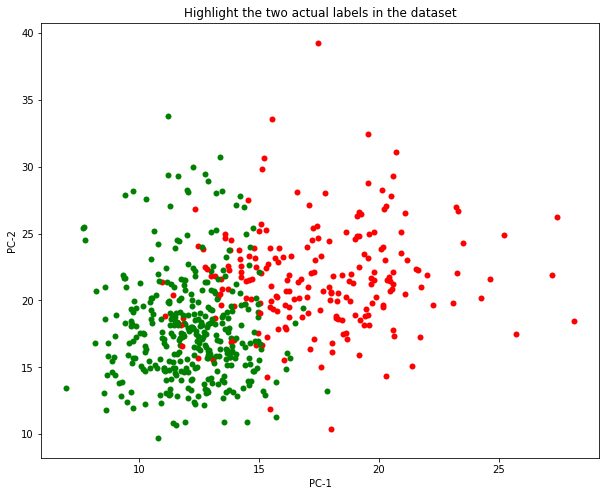

In [76]:
# YOUR CODE HERE
# plot the first two components
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 8))
#print(correct_pred)
f=predictions.toPandas()
f1=predictions_pca.toPandas()
#print(f['features'][0][0])
#print(f['prediction'])
#feat=np.asarray(f['features'], dtype='float32')
preds= np.asarray(f['prediction'], dtype='int32')
preds1= np.asarray(f1['prediction'], dtype='int32')
#print(feat)
#print(preds)
colors=['r', 'g']
for i in range(preds.shape[0]):
       if labels[i]== 0:
          plt.scatter([f['features'][i][0]], [f['features'][i][1]],c=colors[0], linewidths=0)
       else:
          plt.scatter([f['features'][i][0]], [f['features'][i][1]],c=colors[1], linewidths=0)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('Highlight the two actual labels in the dataset')
plt.show()


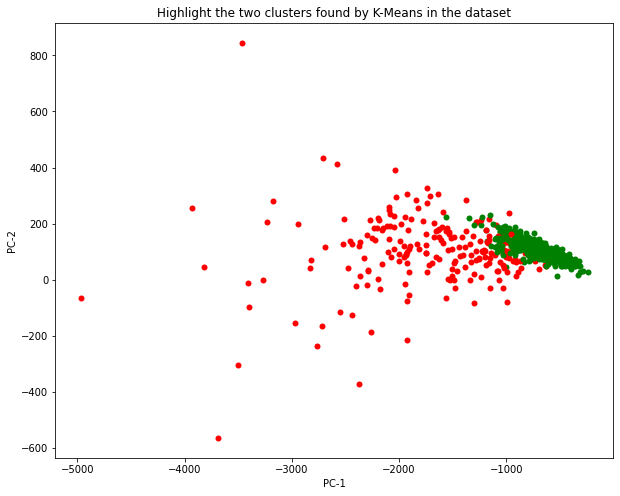

In [77]:
#print(f1)
#print(f)
plt.figure(figsize=(10, 8))

colors=['r', 'g']
for i in range(preds1.shape[0]):
       if labels[i]== 0:
          plt.scatter([f1['features'][i][0]], [f1['features'][i][1]],c=colors[0], linewidths=0)
       else:
          plt.scatter([f1['features'][i][0]], [f1['features'][i][1]],c=colors[1], linewidths=0)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('Highlight the two clusters found by K-Means in the dataset')
plt.show()

#**Question07:**

Repeat the process of Question01 for K = 1 to 10. **Plot** separately

1) the Sihouette score for each K

2) the within cluster sum of squares (WSS) for each K

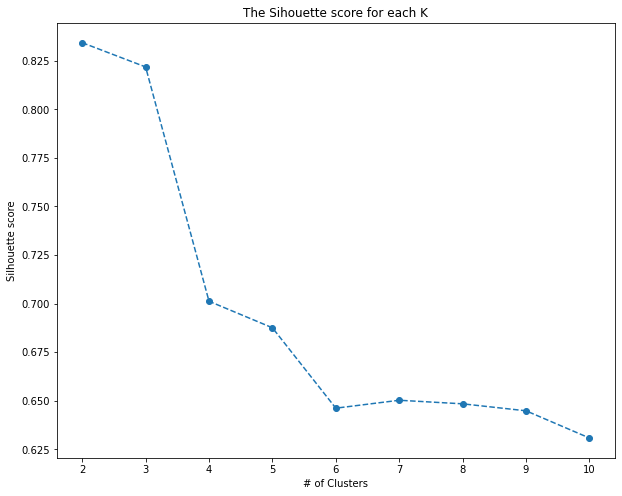

In [18]:
# YOUR CODE HERE
sil_score=[]
for k in range(2,11):
    kmeans = KMeans(k=k)
    model = kmeans.fit(features)

# Make predictions
    predictions = model.transform(features)

# Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    sil_score.append(silhouette)
    #print("Silhouette with squared euclidean distance = " + str(silhouette))

plt.figure(figsize = (10, 8))
plt.plot(range(2,11), sil_score,marker='o',linestyle='--')
plt.xlabel('# of Clusters')
plt.ylabel('Silhouette score')
plt.title('The Sihouette score for each K')
plt.show()

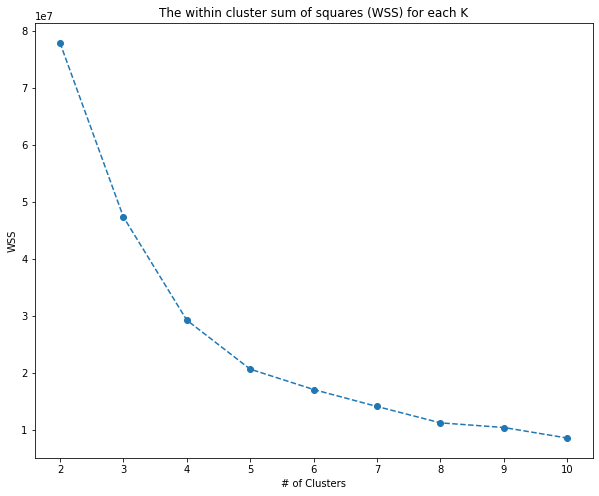

In [19]:
wss=[]
for k in range(2,11):
    kmeans = KMeans(k=k)
    model = kmeans.fit(features)
    cost = model.summary.trainingCost
    wss.append(cost)
    #print("Within Set Sum of Squared Errors = " + str(cost))

plt.figure(figsize = (10, 8))
plt.plot(range(2,11), wss,marker='o',linestyle='--')
plt.xlabel('# of Clusters')
plt.ylabel('WSS')
plt.title('The within cluster sum of squares (WSS) for each K')
plt.show()